In [1]:
'''
Unsupervised clustering on CRISM data 
created on 15/05/2023 by Beatrice Baschetti
latest update: 7/11/23
'''

'\nUnsupervised clustering on CRISM data \ncreated on 15/05/2023 by Beatrice Baschetti\nlatest update: 09/08/23\n'

# Introduction

In this notebook two different unsupervised clustering techniques available in the sci-kit learn library (https://scikit-learn.org/stable/) are applied to CRISM MTRDR I/F data. 
The available clustering algorithms are: 
1) K-means;
2) Gaussian mixture models.

Clustering is carried out on the I/F cube, after a series of important pre-processing steps which include filtering and dimensionality reduction.

It is then possible to plot and save the median spectra of the clusters. The spectra can be extracted either directly from the I/F cube or from a ratioed version of the same cube. 

This script was developed with the support of Dr. Mario D'Amore (DLR-Berlin).

# Import

In [2]:
#numpy
import numpy as np

#pandas
import pandas as pd

#plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

#open envi image
from spectral import open_image

#image stretching
from skimage import exposure

#clustering
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import cluster
from sklearn import mixture

#computing time
import time

#folder/file management
import os


# Open image

In [3]:
#path
path_if = 'data/frt00009b5a_07_if165j_mtr3.hdr'

#-------

#opening I/F file
img = open_image(path_if)
wavelength = np.array(img.metadata['wavelength']).astype(float)

#converting img to simple array and putting no-values to NaN
nan_img = np.copy(img[:,:,:])
nan_img[nan_img>10]=np.nan

# Metadata
It might be useful to create a .txt file containing a dictionary to keep track of the parameters chosen during the data analysis

In [4]:
#getting the filename from path
filename = os.path.splitext(os.path.basename(path_if))[0]

#create dictionary
metadata_dict = {}
metadata_dict['image ID:'] = filename

# Cube visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


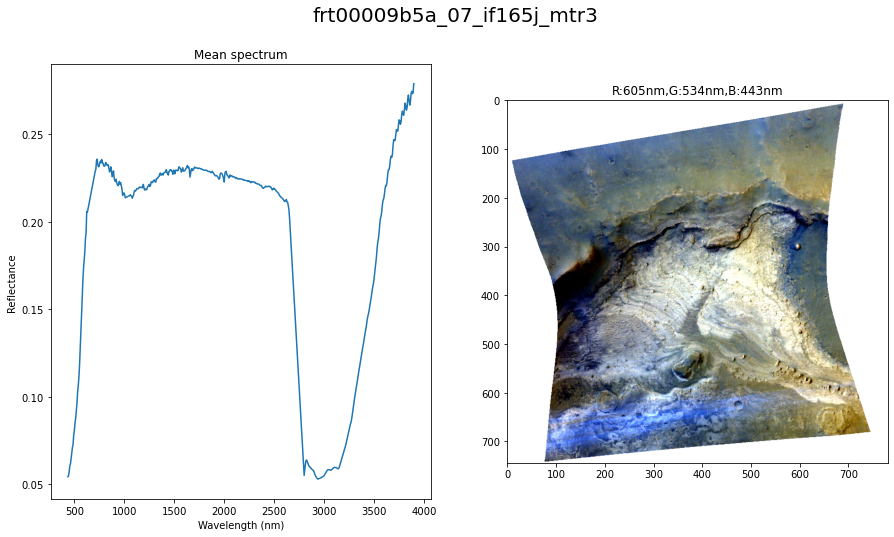

In [5]:
#computing mean spectrum
mean_spec = np.nanmean(nan_img.reshape(-1,nan_img.shape[-1]), axis = 0)

#RGB true color image
wav_channels = [26,15,1] #600nm,530nm,440nm
wav_channels_text = ','.join([f'{c}:{w:.0f}nm' for c,w in zip(['R','G','B'],wavelength[wav_channels])]) #channels text for plot
#slicing to get RGB
RGB = img[:,:,wav_channels]

#contrast stretching: 
for ind, ch in enumerate (RGB.T):
    #masking no-data values
    ch_mask = ch != 65535. 
    #2nd and 98th percentile ignoring no-data values (if present)
    p2, p98 = np.nanpercentile(ch[ch_mask], (2, 98)) 
    RGB[:,:,ind] = exposure.rescale_intensity(ch, in_range=(p2, p98)).T

#plots-----------------------------
fig, axs = plt.subplots(ncols=2,figsize=[15,8])
fig.suptitle(filename, fontsize = 20)
#mean spectrum (mean over the whole scene) plot
axs[0].plot(wavelength, mean_spec)
axs[0].set_title('Mean spectrum')
axs[0].set_xlabel('Wavelength (nm)')
axs[0].set_ylabel('Reflectance')
#image plot
axs[1].set_title(wav_channels_text)
axs[1].imshow(RGB)

#save
plt.savefig('crism_scene',dpi=300)

# Preprocessing

There is a certain number of pre-processing steps to do before applying any clustering algorithm.

1) No-data/invalid values are removed (any value in the reflectance cube which is greater than 1)
2) Wavelength range is restricted between 1 and 2.6 microns. 
3) Data is filtered for artefacts: a) 1.645-1.704 (filter boundary artefact); b) 1.948-2.060 (CO2 artefact)
4) Principal component analysis (PCA) is applied to data to reduce dimensionality
5) You can choose to remove the first component of PCA from data <font color='orange'>(suggested)</font>
6) You can apply UMAP (Uniform Manifold Approximation and Projection for Dimension Reduction) to data to reduce dimensionality <font color='orange'>(optional)</font>
7) Data is scaled so that it has mean = 0 and std dev = 1


## Preprocessing data part 1 (data filtering) 
Parts 1, 2 and 3 of preoprocessing steps are implemented here

In [6]:
#function to find nearest value in a numpy array 
from find_nearest import find_nearest

In [7]:
#create a pandas dataframe
df = pd.DataFrame(img[:,:,:].reshape(-1,img.shape[-1]),
            columns=wavelength/1000.
            )
print("-> df shape (initial data shape): %s" % str(df.shape))
df[df > 1] = np.nan #no-data/invalid values are put as NaNs


#->remove no-data values and resize the data to a smaller wavelength range
start_wav, stop_wav = 1.0, 2.6 #wavelengths between 1.0 and 2.6 microns
start_wav_ind, stop_wav_ind = find_nearest(start_wav,df.columns),find_nearest(stop_wav,df.columns) #get indexes
df_nonan = df.dropna(axis=0,how='all').iloc[:,start_wav_ind:stop_wav_ind] #drop NaN values and restrict wav. range
print("\nno-data values removed")
print("data is restricted between {}-{} nm".format(start_wav, stop_wav))

#->remove ranges with artefacts
#----1.7 filter artefact:---- 
wv1_min_index = 169
wv1_max_index = 178
start_1 = wavelength[wv1_min_index]*0.001
stop_1 = wavelength[wv1_max_index]*0.001
#----CO2 artefact----
wv2_min_index = 215
wv2_max_index = 232
start_2 = wavelength[wv2_min_index]*0.001
stop_2 = wavelength[wv2_max_index]*0.001

print('filter artefact: {:.3f}-{:.3f} nm;\nCO2 artefact: {:.3f}-{:.3f} nm\n'.format(start_1, 
                                                                                    stop_1, 
                                                                                    start_2, 
                                                                                    stop_2))
df_nonan.loc[:,start_1:stop_1] = np.nan #1.7 filter artefact
df_nonan.loc[:,start_2:stop_2] = np.nan #CO2 artefact
#dropping NaN values on the columns (artefact gaps)
df_nonan = df_nonan.dropna(axis=1, how='all')
#-----------------------------------

#check shape
print("-> df_nonan shape (final data shape): %s" % str(df_nonan.shape))

-> df shape (initial data shape): (581064, 489)

no-data values removed
data is restricted between 1.0-2.6 nm
filter artefact: 1.645-1.704 nm;
CO2 artefact: 1.948-2.060 nm

-> df_nonan shape (final data shape): (394890, 211)


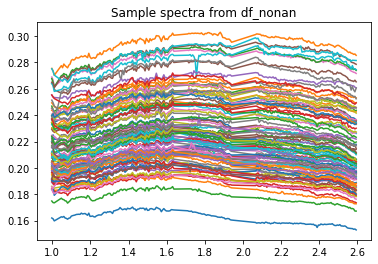

In [8]:
#df_nonan plot to visualize part of the data (gaps are connected by a straight line)
df_nonan.sample(100).T.plot(title = 'Sample spectra from df_nonan', legend=None);

### Save df and df_nonan

In [ ]:
#df and df_nonan dataframes will be used in compute_silhouette.ipynb script, save this only once
#given a specific dataset, df and df_nonan are the same for every clustering algorithm

df.to_pickle("df_"+filename+".pkl")
df_nonan.to_pickle("df_nonan_"+filename+".pkl")

## Preprocessing data, part 2: PCA

Here you can apply principal component analysis (PCA) to reduce dimensionality of the data. 

In [9]:
X = df_nonan.values #data array

n_components = 6 #number of pca components
pca = decomposition.PCA(n_components=n_components)
pca.fit(X)
n_components = pca.n_components_
X_pca = pca.transform(X)

#metadata
metadata_dict['PCA components:'] = n_components


print('X.shape               : {}\n'
      'X_pca.shape           : {}\n'
      'pca.components_.shape : {}'.format(X.shape, X_pca.shape, pca.components_.shape))

print("              variance       var_ratio      cum_var_ratio")
for i in range(n_components):
    print("Component %2s: %12.10f   %12.10f   %12.10f" % (i, pca.explained_variance_[i], 
                                                          pca.explained_variance_ratio_[i], 
                                                          np.cumsum(pca.explained_variance_ratio_)[i]))

X.shape               : (394890, 211)
X_pca.shape           : (394890, 6)
pca.components_.shape : (6, 211)
              variance       var_ratio      cum_var_ratio
Component  0: 0.1466777492   0.9926725975   0.9926725975
Component  1: 0.0006721524   0.0045489333   0.9972215308
Component  2: 0.0002019475   0.0013667221   0.9985882529
Component  3: 0.0000495727   0.0003354939   0.9989237468
Component  4: 0.0000415867   0.0002814469   0.9992051936
Component  5: 0.0000334857   0.0002266217   0.9994318154


initial data size:(581064, 489)
filtered data size:(394890, 211)
data size after PCA:(394890, 6)



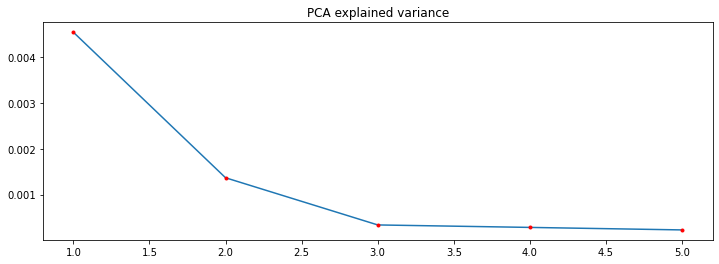

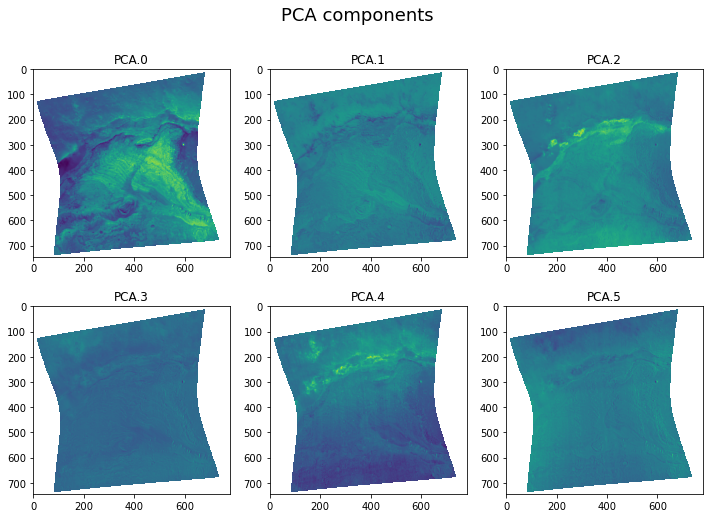

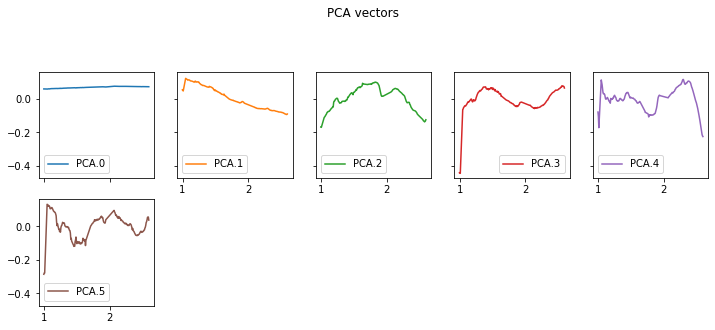

In [10]:
#visualize pca components

print("initial data size:{}\nfiltered data size:{}\ndata size after PCA:{}\n".format(df.shape,df_nonan.shape,X_pca.shape))
    
#---------plot of explained variance---------
components_shift = 1 #if components_shift=1 first pca component is not shown in the figure
fig = plt.figure(figsize=(12,4))
ax = plt.subplot()
ax.plot(np.arange(pca.n_components-components_shift)+components_shift, pca.explained_variance_ratio_[components_shift:])
ax.plot(np.arange(pca.n_components-components_shift)+components_shift, pca.explained_variance_ratio_[components_shift:], "r.")
ax.set_title("PCA explained variance")
#ax.set_yscale('log')
plt.show()  

    
#---------plot pca components---------
plot_df = pd.DataFrame(index=df.index) #plot dataframe

for cmp in range(pca.n_components):
    plot_df[f'PCA.{cmp}'] = np.nan 
    
plot_df.loc[df_nonan.index] = X_pca

fig, axs = plt.subplots(nrows=2,ncols=3, figsize=[12,8]) #rows and columns can be manually adjusted based on n_components
fig.suptitle("PCA components", size = 18)
axs = axs.flatten()
    
for ind, ax in enumerate(axs):
    if ind < n_components:
        ax.imshow(plot_df.iloc[:,ind].values.reshape(img.shape[:-1]))
        ax.set_title(plot_df.columns[ind])
                       
#---------plot pca vectors--------- 
pca_vectors = pd.DataFrame(columns=df_nonan.columns,
                        index=[ f'PCA.{cmp}' for cmp in range(pca.n_components)],
                        data=pca.components_)

pca_vectors.T.plot(subplots=True,figsize=[12,9], layout = (4,5), sharey = True, title = 'PCA vectors');

### Remove first component of PCA (suggested)
Removing the first component of the PCA from the data will remove the dependency on reflectance of the clustering algorithms. 

In [11]:
#first component of X_pca is removed (run this cell only once!)
X_pca = X_pca[:,1:]
#metadata
metadata_dict['PCA components removed:'] = "first component"

## Preprocessing data, part 3: UMAP (optional)
Umap stands for "Uniform Manifold Approximation and Projection for Dimension Reduction" and is a dimension-reduction technique.
More info can be found here: https://umap-learn.readthedocs.io/en/latest/# and here: https://pair-code.github.io/understanding-umap/

In [12]:
#import
import umap
#short function to compute umap
def compute_UMAP(umap_data, 
                 neighbors, 
                 mindistances): 
                     
    X = umap.UMAP(n_neighbors=neighbors, min_dist = mindistances).fit_transform(umap_data)
                     
    return X

### Compute umap grid

In this part of code you can run umap algorith with different initial parameters (a grid of different nearest neighbours and minimum distance values). This will help you explore how umap maps the data and help you choose the best values for the nearest neighbor and minimum distance. Computed values will be saved in a separate file so that you can access them later.

<font color='orange'>Careful! This part is computationally expensive, you should run it once and then use the saved data for the next part of the code (clustering algorithm application).</font>

In [12]:
import pathlib
from pathlib import Path

#range of nearest neighbors and ninimum distances to try
neighbors = [25, 50, 100] #the bigger this number the more computationally expensive the algorithm, max 500 suggested
mindistances = [0.2, 0.5, 0.8]

#umap is applied to PCA data
umap_data = X_pca

#write data
for n in neighbors:
    for d in mindistances:

        cached_umap = pathlib.Path('UMAP/UMAP_grid/umap_embedding_neighbors-{}_mindist-{}.npy'.format(n,d))
        if cached_umap.is_file():
            print('File with neigh={}, mindist={} already exists'.format(n,d))
            
        else: 
            print('Computing UMAP for neigh={}, mindist={}...'.format(n,d))
            results = compute_UMAP(umap_data, n, d)
            np.save(cached_umap,results) 
            del results

print('done!')

File with neigh=25, mindist=0.2 already exists
File with neigh=25, mindist=0.5 already exists
File with neigh=25, mindist=0.8 already exists
File with neigh=50, mindist=0.2 already exists
File with neigh=50, mindist=0.5 already exists
File with neigh=50, mindist=0.8 already exists
File with neigh=100, mindist=0.2 already exists
File with neigh=100, mindist=0.5 already exists
File with neigh=100, mindist=0.8 already exists
done!


### Load UMAP grid
Load your UMAP grid if you already have one computed with the code above.

In [13]:
#load data
import pathlib
from pathlib import Path

neighbors = [25, 50, 100]
mindistances = [0.2, 0.5, 0.8]
#results dictionary
results_dict = {}

for n in neighbors:
    for d in mindistances:  
        cached_umap = pathlib.Path('UMAP/UMAP_grid/umap_embedding_neighbors-{}_mindist-{}.npy'.format(n,d))
        results_dict[(n,d)] = np.load(cached_umap)     


label = [(n,d) for n in neighbors for d in mindistances]

### Plot loaded UMAP grid

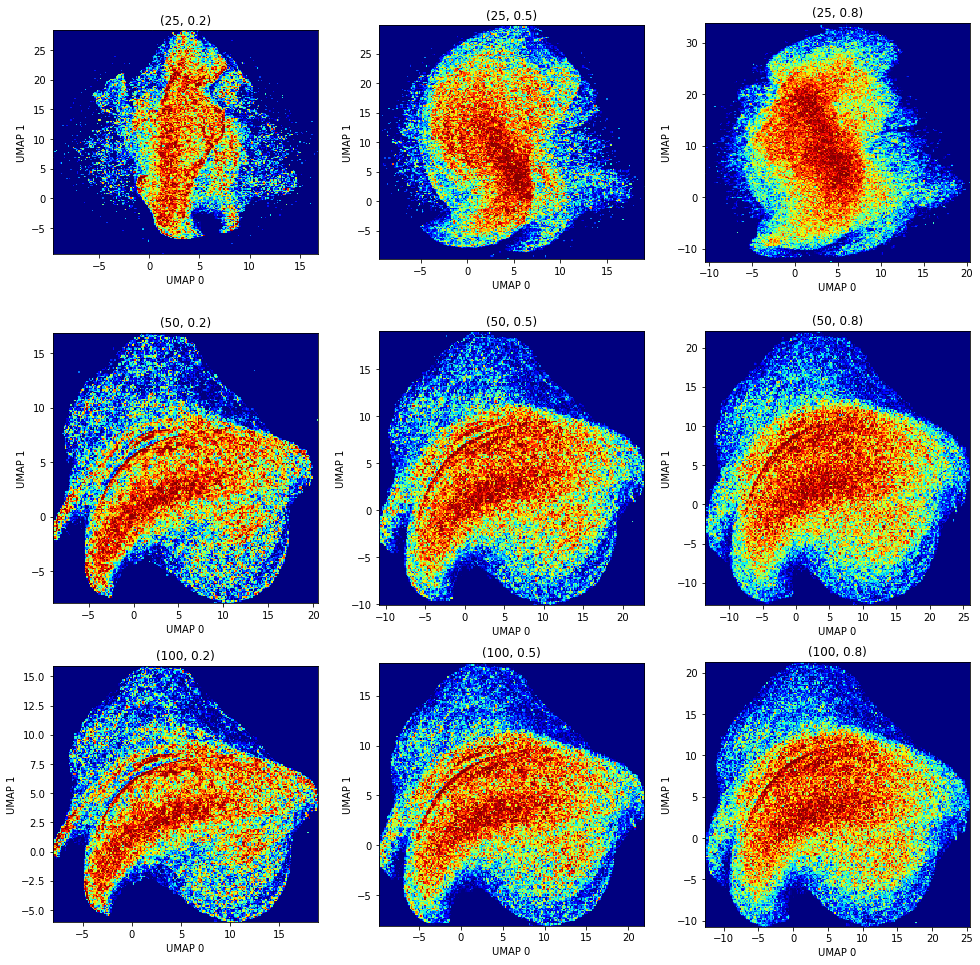

In [14]:
fig, axs = plt.subplots(3,3, figsize=(14,14))
#plt.subplots_adjust(wspace = 0.1, hspace=0.5)
axs = axs.flatten()
fig.tight_layout(pad = 3)

# Define the number of bins
nxbins = 200
nybins = 200
nbins = 200

for i, keys in enumerate(label):
    data = results_dict[keys]
    X = data[:,0]
    Y = data[:,1]

    #find the min max of data
    xmin = min(X)
    xmax = max(X)
    ymin = min(Y)
    ymax = max(Y)

    # Make the 'main' plot

    xbins = np.linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = np.linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = 1.0*(xmax - 0)/(1.0*ymax - 0)
 
    H, xedges,yedges = np.histogram2d(Y,X,bins=(ybins,xbins))

    axs[i].imshow(exposure.equalize_hist(H), extent=[xmin,xmax,ymin,ymax], interpolation='nearest', origin='lower',aspect=aspectratio, cmap = 'jet')

    #set title
    axs[i].set_title(keys)
    
    #plot axes labels
    axs[i].set_xlabel('UMAP 0',fontsize=10)
    axs[i].set_ylabel('UMAP 1',fontsize=10)

plt.savefig('UMAP_grid.png',dpi=300)
    

### Choose UMAP result
Choose the best nearest neighbor/minimum distance set based on the grid above. This data will be passed to the clustering algorithms.

In [15]:
#chosen parameters
n_neigh = 100
min_dist = 0.2
#get data from results dictionary
X_umap = results_dict[(n_neigh,min_dist)]
#print info
print('Nearest neighbours:{}; Minimum distance:{}'.format(n_neigh, min_dist))
print("initial data size:{}\nfiltered data size:{}\ndata size after PCA:{}\ndata size after UMAP:{}".format(df.shape,
                                                                                                            df_nonan.shape,
                                                                                                            X_pca.shape,
                                                                                                            X_umap.shape))
#add metadata
metadata_dict['UMAP'] = 'Nearest neighbours:{}; Minimum distance:{}'.format(n_neigh, min_dist)

Nearest neighbours:100; Minimum distance:0.2
initial data size:(581064, 489)
filtered data size:(394890, 211)
data size after PCA:(394890, 5)
data size after UMAP:(394890, 2)


# Clustering
There are several kinds of estimators https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html 

For CRISM hyperspectral data k-means and gaussian mixture work fine, and they are fast.

## Scaler
Data needs to be scaled before passing them to the clustering algorithm -> https://scikit-learn.org/stable/modules/preprocessing.html

Here the "standard scaler" is used -> https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

Run the cell below assigning either X_pca or X_umap to X_to_scale variable (i.e. put X_pca if you skipped the UMAP part).

In [16]:
#----------!!!-----------
#put X_pca if you skip UMAP part. Else, put X_umap
#----------!!!-----------
X_to_scale = X_umap #<---
scaler = preprocessing.StandardScaler().fit(X_to_scale)
X_scaled = scaler.transform(X_to_scale)

#scaled data has zero mean and unit variance
print('Scaled data info\n')
print('Mean:',X_scaled.mean(axis=0))
print('Std:',X_scaled.std(axis=0))

#metadata
metadata_dict['Scaler'] = 'Standard scaler'

Scaled data info

Mean: [-2.3925113e-06 -4.2544993e-06]
Std: [0.99993587 0.99990517]


### Save scaled data

In [17]:
#save scaled data
np.save('X_scaled.npy', X_scaled)

## Clustering algorithms
You can choose between k-means algorithm (https://scikit-learn.org/stable/modules/clustering.html#k-means) and gaussian mixture models (https://scikit-learn.org/stable/modules/mixture.html#mixture)

In [18]:
#----------- K-means -----------------

from sklearn import cluster

classifier = 'K-Means'
n_clusters = 12

#computation time start
start_time = time.time()

#K-means estimator instance + classify scaled data
k_means = cluster.KMeans(n_clusters=n_clusters, init = 'k-means++', n_init=1, random_state=1111).fit(X_scaled)
labels = k_means.labels_
print('k_means.inertia_ : ',k_means.inertia_)

#computation time end
end_time = time.time()
computation_time = end_time - start_time
#print computation time
print("Computation time:", computation_time, "seconds")


#metadata
metadata_dict['Classifier'] = classifier
metadata_dict['Number of clusters'] = n_clusters
metadata_dict['Inertia'] = k_means.inertia_

'''


#------------ Gaussian Mixture -------------

from sklearn import mixture

classifier = 'Gaussian Mixture'
n_clusters = 15

#computation time start
start_time = time.time()

#choose from: full, tied, diag, spherical 
covariance_type = 'diag'
#choose from: kmeans, k-means++, random, random_from_data
init_params = 'kmeans'
g_mixture = mixture.GaussianMixture(n_components=n_clusters, random_state=0, covariance_type = covariance_type, init_params = init_params)
labels = g_mixture.fit_predict(X_scaled) 

#computation time end
end_time = time.time()
computation_time = end_time - start_time
#print computation time
print("Computation time:", computation_time, "seconds")


#metadata
metadata_dict['Classifier'] = classifier
metadata_dict['Number of clusters'] = n_clusters
metadata_dict['Covariance type'] = covariance_type
metadata_dict['init params'] = init_params
'''

k_means.inertia_ :  73141.765625
Computation time: 0.6116399765014648 seconds


'\n\n\n#------------ Gaussian Mixture -------------\n\nfrom sklearn import mixture\n\nclassifier = \'Gaussian Mixture\'\nn_clusters = 15\n\n#computation time start\nstart_time = time.time()\n\n#choose from: full, tied, diag, spherical \ncovariance_type = \'diag\'\n#choose from: kmeans, k-means++, random, random_from_data\ninit_params = \'kmeans\'\ng_mixture = mixture.GaussianMixture(n_components=n_clusters, random_state=0, covariance_type = covariance_type, init_params = init_params)\nlabels = g_mixture.fit_predict(X_scaled) \n\n#computation time end\nend_time = time.time()\ncomputation_time = end_time - start_time\n#print computation time\nprint("Computation time:", computation_time, "seconds")\n\n\n#metadata\nmetadata_dict[\'Classifier\'] = classifier\nmetadata_dict[\'Number of clusters\'] = n_clusters\nmetadata_dict[\'Covariance type\'] = covariance_type\nmetadata_dict[\'init params\'] = init_params\n'

## Visualize clusters

### Relabelling of features with centroids (optional)
Normally, the k-means algorithm assigns labels to clusters randomly.
In this part of the code you can change how the labels are assigned to the clusters as originally implemented here https://gist.github.com/kidpixo/6ec6c6c575e19b09da3d2207efa38b24

Labels are assigned based on the reflectance value at a chosen wavelength of each class' mean spectrum. If the generated classes are similar between k-means algorithm and GMMs, colors should stay the same allowing the user to easily compare the different methods.

In [19]:
y = df_nonan.groupby(labels).mean().values #get mean spectrum of each cluster

In [20]:
feature_index = find_nearest(2.1, df_nonan.columns.values) #choose the wavelength and get the corresponding index
centroids_sorting_index = np.argsort(y[:, feature_index]) #get index that sorts y at the chosen feature 
centroids_sorted_labels = np.argsort(centroids_sorting_index) #this operation produces an array with the sorted labels 

In [21]:
#visualize the sorting steps
pd.DataFrame(data=[np.unique(labels),y[:, feature_index],centroids_sorting_index,centroids_sorted_labels],
            index=['labels',f'cluster mean (refl) at  {df_nonan.columns[feature_index]:1.3f} um','centroids_sorting_index','centroids_sorted_labels']).T

,labels,cluster mean (refl) at 2.100 um,centroids_sorting_index,centroids_sorted_labels
0,0.0,0.212908,5.0,1.0
1,1.0,0.228818,0.0,7.0
2,2.0,0.216897,10.0,3.0
3,3.0,0.222582,2.0,5.0
4,4.0,0.237739,11.0,10.0
5,5.0,0.202273,3.0,0.0
6,6.0,0.241120,9.0,11.0
7,7.0,0.231658,1.0,8.0
8,8.0,0.236540,7.0,9.0
9,9.0,0.224338,8.0,6.0


In [22]:
# change the classes with the new integers 
labels = pd.Series(labels).map(dict(zip(np.arange(n_clusters), centroids_sorted_labels))).values.squeeze()

#visualize old and new indexes
print(f'index for label sort: index : {feature_index} - wav : {df_nonan.columns[feature_index]:1.3f} um')
print(f'ind : y_feat > new_index')
for i, yf, ni in zip(range(len(y[:, feature_index])),y[:,feature_index], centroids_sorted_labels):
    print(f'{i:3} : {yf:2.3f} > {ni:>4}')

index for label sort: index : 135 - wav : 2.100 um
ind : y_feat > new_index
  0 : 0.213 >    1
  1 : 0.229 >    7
  2 : 0.217 >    3
  3 : 0.223 >    5
  4 : 0.238 >   10
  5 : 0.202 >    0
  6 : 0.241 >   11
  7 : 0.232 >    8
  8 : 0.237 >    9
  9 : 0.224 >    6
 10 : 0.215 >    2
 11 : 0.221 >    4


### Assign labels

In [23]:
#going back to data cubes
class_plot_df = pd.DataFrame(index=df.index)

#assign labels
class_plot_df['labels'] = np.nan
labels = labels.reshape(-1,1)
class_plot_df.loc[df_nonan.index] = labels

## Save class dataframe

In [24]:
#save class_plot_df if you need it for further analysis with other scripts
import pickle
class_plot_df.to_pickle('class_plot_df.pkl')

### Plot

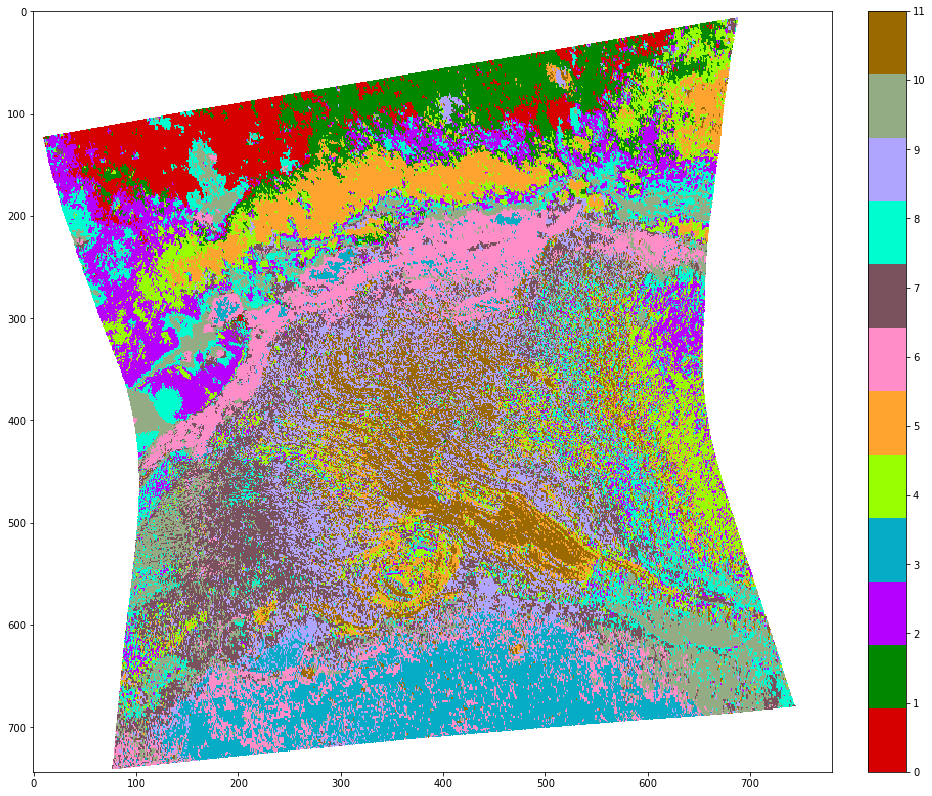

In [27]:
#colorcet -> https://colorcet.holoviz.org/user_guide/Categorical.html
import colorcet as cc

#plotting the clusters----------

fig = plt.subplots(figsize=(16,14))

#colors
color_list = cc.glasbey_light[:n_clusters]
cmap = ListedColormap(color_list)

#since the new clusters labels are based on reflectance values of a certain feature
#with a continuous color map you can shown how these values change with the class
#in that case you can uncomment the line below
#cmap = plt.cm.Spectral_r 
 
im = plt.imshow(class_plot_df['labels'].values.reshape(img.shape[:-1]),interpolation='None',cmap=cmap) 

#color bar
cbar = plt.colorbar(im, fraction = 0.05, pad = 0.04)

# Set the number of ticks on the color bar
num_ticks = n_clusters
cbar.locator = plt.MaxNLocator(num_ticks)
# Update the color bar
cbar.update_ticks()

#save img (make sure to save at a high-res!)
plt.savefig('img_clusters.png', dpi= 300)

plt.show()


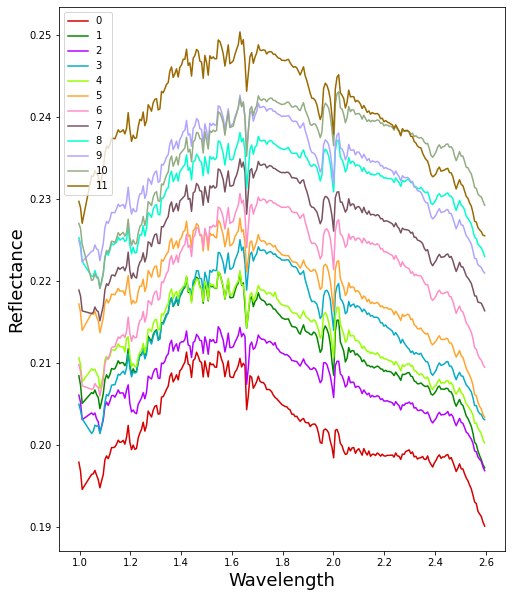

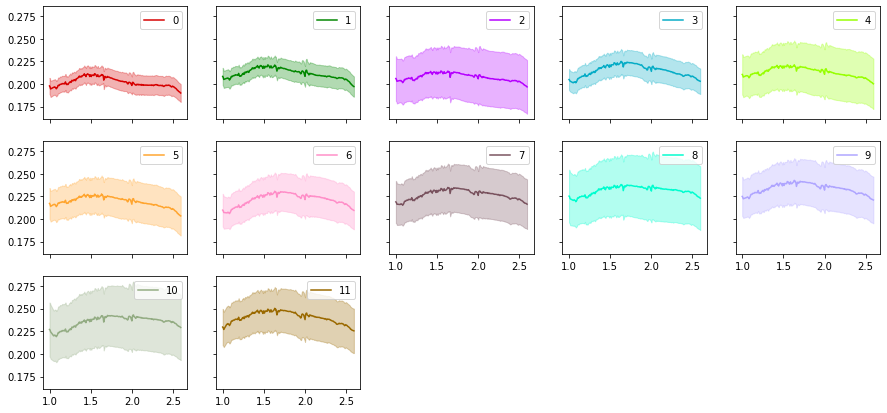

In [26]:
#plotting the median spectra of the clusters identified by the algorithm

start_wav, stop_wav = 1.0, 2.6 #reduce data to wavelengths between 1.0 and 2.6 microns
start_wav_ind , stop_wav_ind = find_nearest(start_wav,df.columns),find_nearest(stop_wav,df.columns)
#-------------- read df again
#using pandas dataframes
df = pd.DataFrame(img[:,:,:].reshape(-1,img.shape[-1]),
            columns=wavelength/1000.
            )
#putting rows and columns with no-data values to NaN
df[df > 1] = np.nan #no data values
#--------------
#drop nans
df_nonan = df.dropna(
    axis=0,how='all').iloc[:,start_wav_ind:stop_wav_ind]


# Plot median values all in one figure--------------
spectra = df_nonan.groupby(labels.squeeze()).agg(np.median).T
ax = spectra.plot(figsize=[8,10], cmap = cmap)
#labels
ax.set_xlabel('Wavelength', fontsize=18)
ax.set_ylabel('Reflectance', fontsize = 18)
#save
plt.savefig('plot_spectra.png')


#plot each spectrum separately--------------
# Calculate median and standard deviation for each cluster
grouped_data = df_nonan.groupby(labels.squeeze())
median_values = grouped_data.median()
std_values = grouped_data.std()
#plot
axs = median_values.T.plot(subplots=True, figsize=[15,12], layout = (5,5), sharey = True, cmap = cmap)
axs = axs.flatten()
for i, row in enumerate(median_values.index):
    axs[i].fill_between(median_values.columns, 
                        median_values.iloc[i,:]-std_values.iloc[i,:], 
                        median_values.iloc[i,:]+std_values.iloc[i,:], 
                        alpha=0.3, 
                        color = cmap(i))
#save
plt.savefig('plot_spectra_separate_std.png')
#save spectra to csv
spectra.to_csv('spectra.csv')

# Save metadata
Remember to save the metadata dictionary to keep track of all relevant parameters!

In [28]:
#save metadata 
with open('Classification_metadata.txt', 'w') as f:
    f.write(str(metadata_dict))

# Load ratioed cube
If you have a ratioed cube at your disposal, you can see how the ratioed spectra look like for each cluster. To get a ratioed version of MTRDR cubes see https://github.com/beatricebs/crism-python-data-analysis/blob/main/CRISM_ratioed_cube_MTRDR.ipynb

In [29]:
#path
path_if_ratioed = 'data/ratio/frt00009b5a_07_if165j_mtr3_RATIOED.hdr'
#opening file
img_ratioed = open_image(path_if_ratioed)
#dataframe
df_ratioed = pd.DataFrame(img_ratioed[:,:,:].reshape(-1,img_ratioed.shape[-1]),
            columns=wavelength/1000.
            )
#drop nans
df_ratioed = df_ratioed.dropna(axis=0,how='all').iloc[:,start_wav_ind:stop_wav_ind]

### Plot

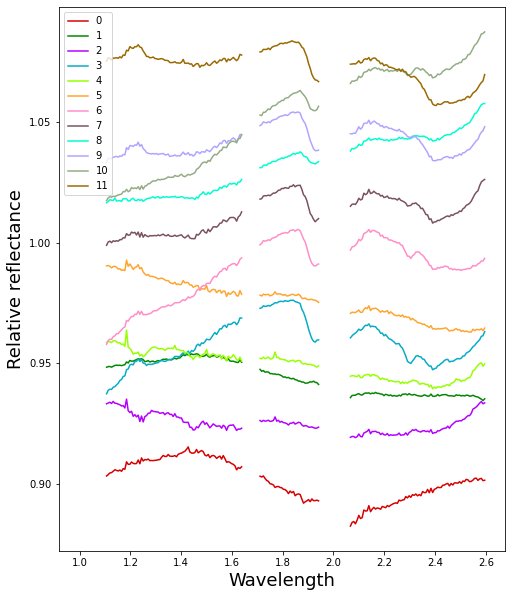

In [30]:
#plot

#mask artefacts
df_ratioed.loc[:,start_1:stop_1] = np.nan #1.7 filter artefact
df_ratioed.loc[:,start_2:stop_2] = np.nan #CO2 artefact

#mask first part of spectrum
df_ratioed.loc[:,1:1.1] = np.nan

spectra_ratioed = df_ratioed.groupby(labels.squeeze()).agg(np.nanmedian).T
ax = spectra_ratioed.plot(figsize=[8,10], cmap = cmap)

ax.set_xlabel('Wavelength', fontsize=18)
ax.set_ylabel('Relative reflectance', fontsize = 18)

#save
plt.savefig('plot_spectra_ratioed.png')
#save spectra
spectra_ratioed.to_csv('spectra_ratioed.csv')

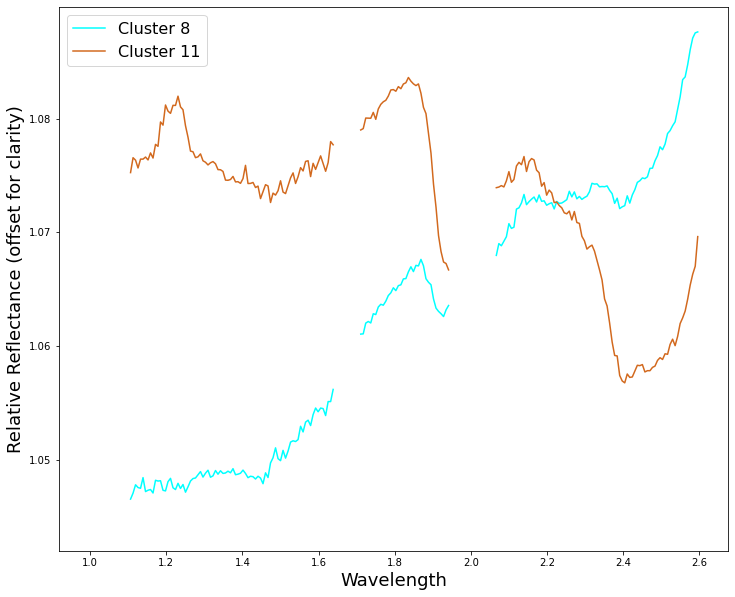

In [31]:
#plot only chosen spectra from the clusters above

plt.figure(figsize=(12,10))
plt.plot(spectra_ratioed.iloc[:,8]+0.03, color= 'aqua') #+0.03 offset (can be varied according to needs)
plt.plot(spectra_ratioed.iloc[:,11], color = 'chocolate')
#legend, axes labels
plt.legend(["Cluster 8", "Cluster 11"], fontsize = 16)  
plt.xlabel("Wavelength", size =18)
plt.ylabel("Relative Reflectance (offset for clarity)", size = 18)

#save
plt.savefig('plot_spectra_ratioed_2.png')